<a href="https://colab.research.google.com/github/scsanjay/ml_from_scratch/blob/main/07.%20Decision%20Tree/DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Custom implementation of Decision Tree Classfier

In [99]:
import numpy as np

In [100]:
class DecisionTreeClassifier:
  """
  Decision Tree Classification with Gini Impurity.

  Parameters
  ----------
  max_depth : int, default=None
    Maximum depth that the tree can have. If None then tree grows till node
    have samples less than min_samples_split or gini impurity becomes 0 
    that means pure node.
  
  min_samples_split : int, default = 2
    Minimum number of samples required in the node to be considered
    for next split.
  """

  def __init__ (self, max_depth=None, min_samples_split=2):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split

  def _get_gini_impurity(self, left_node, right_node):
    gini = 0
    left_node_n = len(left_node)
    right_node_n = len(right_node)
    total_samples = left_node_n + right_node_n

    # gini impurity of left node
    left_node_gini = 1
    for unique_class in set(left_node):
      left_node_gini -= np.power(
            np.count_nonzero(left_node == unique_class)/left_node_n, 
            2
          )
      
    # gini impurity of right node
    right_node_gini = 1
    for unique_class in set(right_node):
      right_node_gini -= np.power(
            np.count_nonzero(right_node == unique_class)/right_node_n, 
            2
          )
    
    # weigted gini impurity
    weigted_gini_impurity = (left_node_gini*left_node_n/total_samples) + \
                            (right_node_gini*right_node_n/total_samples)

    return weigted_gini_impurity, total_samples

  def _get_best_split(self, x, y):
    gini = 999
    # transposed, now row represents features
    x_t = x.T
    # loop over each feature
    for j, feature_data in enumerate(x_t):
      feature_data_sorted = np.sort(np.unique(feature_data))
      # try different thresholds
      for i in range(1, len(feature_data_sorted)):
        threshold = (feature_data_sorted[i-1]+feature_data_sorted[i])/2
        thresholded_index = feature_data<=threshold

        left_node_class = y[thresholded_index==True]
        right_node_class = y[thresholded_index==False]
        
        # Get gini impurity based on current childs
        gini_temp, total_samples = self._get_gini_impurity(left_node_class, right_node_class)
        
        if (gini_temp<gini):
          gini = gini_temp
          feature_index = j
          feature_threshold = threshold
          samples = total_samples
          
          # create left node
          left_node_data = x[thresholded_index==True]
          left_node = [left_node_data, left_node_class]

          # create right node
          right_node_data = x[thresholded_index==False]
          right_node = [right_node_data, right_node_class]
      
    # create node
    result_node = {
        'feature_index':feature_index,
        'feature_threshold':feature_threshold,
        'gini':gini,
        'samples':samples,
        'childs':[left_node, right_node]
    }
    return result_node

  def _make_leaf_node(self, node1):
    classes = node1[1]
    predicted = np.bincount(classes).argmax()
    return predicted

  def _split_tree(self, node, depth=1):
    """recursively build the decision tree"""
    left_node, right_node = node['childs']
    del(node['childs'])

    # if max depth reached then stop growing
    if self.max_depth is not None and depth>=self.max_depth:
      node['left'] = self._make_leaf_node(left_node)
      node['right'] = self._make_leaf_node(right_node)
      return 

    # if gini impurity 0 then stop
    if node['gini'] == 0:
      node['left'] = self._make_leaf_node(left_node)
      node['right'] = self._make_leaf_node(right_node)
      return 

    # work on left child
    if self.min_samples_split>len(left_node[1]):
      node['left'] = self._make_leaf_node(left_node)
    else:
      node['left'] = self._get_best_split(left_node[0], left_node[1])
      self._split_tree(node['left'])

    # work on right child
    if self.min_samples_split>len(right_node[1]):
      node['right'] = self._make_leaf_node(right_node)
    else:
      node['right'] = self._get_best_split(right_node[0], right_node[1])
      self._split_tree(node['right'])
  
  def _build_tree(self, x,y):
    """get root node and start building the tree"""
    node = self._get_best_split(x, y)
    self._split_tree(node)
    return node
    
  def fit(self, X_train, y_train):
    """
    # It will create the decision tree based on train data

    Parameters
    ----------
    X_train : array of shape (n_samples, n_features)

    Y_train : array of shape (n_samples)

    Returns
    -------
    self : object
    """
    self.tree = self._build_tree(X_train, y_train)
    return self

  def predict(self, X_test):
    """
    It will predict the output classes for the test data.

    Parameters
    ----------
    X_test : array of shape (n_samples, n_features)

    Returns
    -------
    predictions : array of shape (n_samples,)
    """
    predictions = []
    # loop over each test data
    for x in X_test:
      predicted = self._predict_class(self.tree, x)
      predictions.append(predicted)
    return np.array(predictions)

  def _predict_class(self, node, x):
    """recursively find the leaf node to predict the class"""
    if x[node['feature_index']] <= node['feature_threshold']:
      if isinstance(node['left'], dict):
        return self._predict_class(node['left'], x)
      else:
        return node['left']
    else:
      if isinstance(node['right'], dict):
        return self._predict_class(node['right'], x)
      else:
        return node['right']

## Validation of the custom implementation

In [101]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, train_size=.8)

In [102]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

In [103]:
y_pred = clf.predict(X_test)

In [104]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [105]:
accuracy_score(y_test, y_pred)

1.0

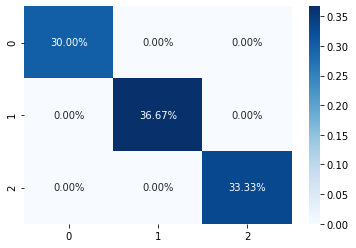

In [106]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

**We got 100% accuracy. That's the best.**